<a href="https://colab.research.google.com/github/jasonix5/AIVC_NLP/blob/main/AIVC_NLP_Twitter_Airline_Sentiment_Analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

## Libraries to be installed

## Importing Libraries

In [ ]:
#General Libraries
import re
import nltk
import time
import emoji
import string
import sklearn
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt

#NLTK Libraries
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet, stopwords
#NLTK resources
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')

# Machine Learning Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support, classification_report

# TensorFlow/Keras Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Transformers Libraries
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer

# Visualization Libraries
from wordcloud import WordCloud
from gensim.models import Word2Vec

## Starting time for execution time calculation

In [ ]:
starting = time.time()

# 1. Domain Selection and Dataset Creation:

## Loading Dataset(s)

In [ ]:
tweets_df = pd.read_csv("Tweets.csv") # Load the main dataset containing tweets
testing_df = pd.read_csv("test_data.csv") # Load a secondary dataset for testing

## Exploring Dataset(s)

### Display the first 5 rows of the tweets dataset for inspection

In [ ]:
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Display the first 5 rows of the testing dataset for inspection

In [ ]:
testing_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_length,clean_text,tokens_no_stopwords,tokens_lemmatized
0,569731104070115329,positive,1.0000,Unknown,NaN,Southwest,NaN,JasmineDT,NaN,1,@SouthwestAir you're my early frontrunner for ...,NaN,2015-02-22 21:30:54 -0800,Washington D.C.,Eastern Time (US & Canada),71,youre my early frontrunner for best airline,"['youre', 'early', 'frontrunner', 'best', 'air...","['youre', 'my', 'early', 'frontrunner', 'for',..."
1,569263373092823040,negative,1.0000,Cancelled Flight,1.0000,US Airways,NaN,ElizabethFrayer,NaN,0,@USAirways how is it that my flt to EWR was Ca...,NaN,2015-02-21 14:32:19 -0800,NaN,NaN,112,how is it that my flt to EWR was Cancelled Fli...,"['flt', 'ewr', 'cancelled', 'flightled', 'yet'...","['how', 'is', 'it', 'that', 'my', 'flt', 'to',..."
2,568818669024907264,negative,1.0000,Late Flight,0.6770,Delta,NaN,The_Radifier,NaN,0,@JetBlue what is going on with your BDL to DCA...,NaN,2015-02-20 09:05:13 -0800,"Arlington, VA",Atlantic Time (Canada),117,what is going on with your BDL to DCA flights ...,"['going', 'bdl', 'dca', 'flights', 'yesterday'...","['what', 'is', 'going', 'on', 'with', 'your', ..."
3,567775864679456768,neutral,1.0000,Unknown,NaN,Delta,NaN,rnlewisjr,NaN,0,@JetBlue do they have to depart from Washingto...,NaN,2015-02-17 12:01:29 -0800,"iPhone: 60.495510,-151.064590",Alaska,55,do they have to depart from Washington DC,"['depart', 'washington', 'dc']","['do', 'they', 'have', 'to', 'depart', 'from',..."
4,568526521910079488,negative,0.6625,Customer Service Issue,0.3394,Delta,NaN,beantoon,NaN,0,@JetBlue I can probably find some of them. Are...,NaN,2015-02-19 13:44:20 -0800,"Plymouth, MA",NaN,70,I can probably find some of them Are the ticke...,"['probably', 'find', 'ticket']","['i', 'can', 'probably', 'find', 'some', 'of',..."


## Exploratory Data Analysis (EDA)

### Class Distribution

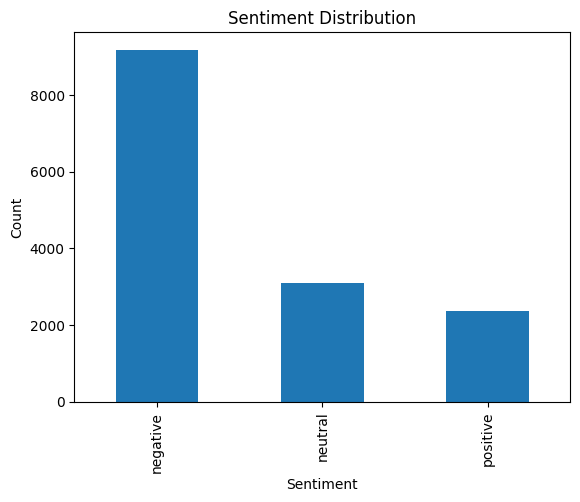

In [ ]:
# Count sentiment labels
sentiment_counts = tweets_df['airline_sentiment'].value_counts()

# Plot distribution
sentiment_counts.plot(kind='bar', title='Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Text Length Analysis

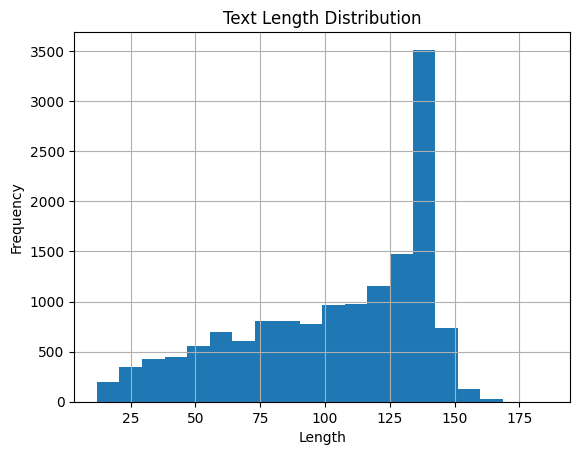

In [ ]:
# Add a column for text length
tweets_df['text_length'] = tweets_df['text'].apply(len)

# Plot histogram of text lengths
tweets_df['text_length'].hist(bins=20)
plt.title('Text Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### Word Clouds for Each Sentiment

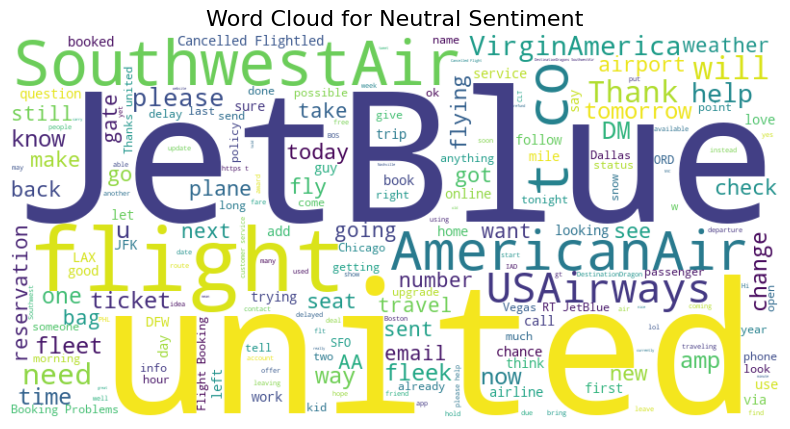

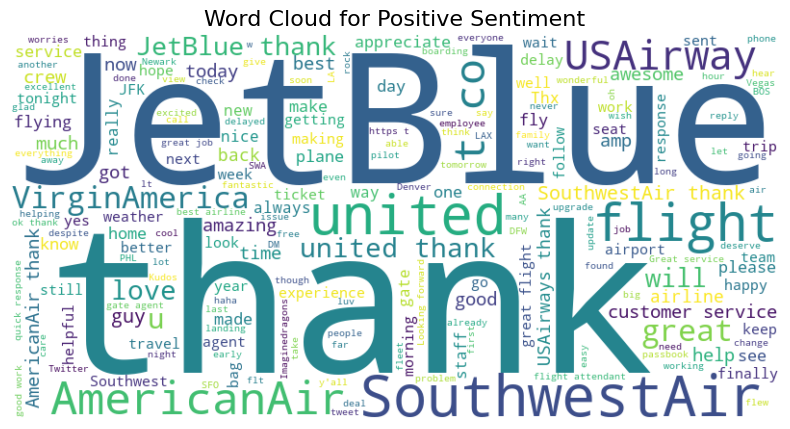

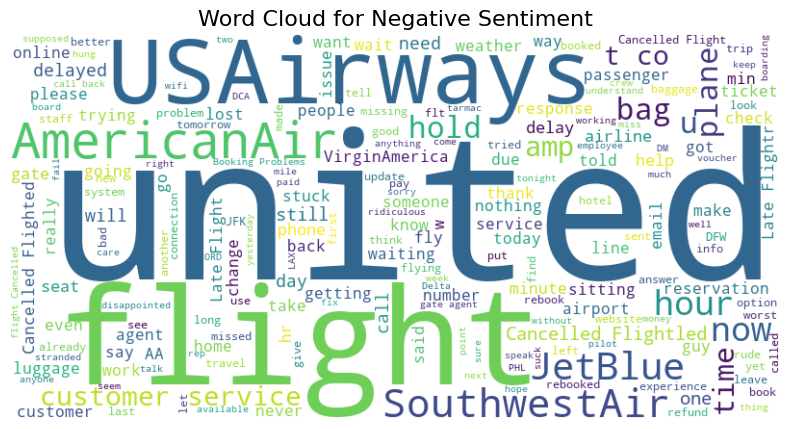

In [ ]:
# Function to create and display a word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)  # Generate the word cloud
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud image
    plt.axis('off')  # Turn off axis display
    plt.title(title, fontsize=16)  # Set the title
    plt.show()  # Show the word cloud

# Create and plot word clouds for each sentiment
for sentiment in tweets_df['airline_sentiment'].unique():
    sentiment_text = ' '.join(tweets_df[tweets_df['airline_sentiment'] == sentiment]['text'])  # Combine all text for this sentiment
    plot_wordcloud(sentiment_text, f"Word Cloud for {sentiment.capitalize()} Sentiment")  # Plot the word cloud

### Top Words in Each Sentiment

In [ ]:
stop_words = set(stopwords.words('english'))

# Function to get most common words
def get_top_words(texts, n=10):
    all_words = ' '.join(texts).split()
    filtered_words = [word.lower() for word in all_words if word.lower() not in stop_words]
    return Counter(filtered_words).most_common(n)

# Top words for each sentiment
for sentiment in tweets_df['airline_sentiment'].unique():
    print(f"Top words for {sentiment}:")
    sentiment_texts = tweets_df[tweets_df['airline_sentiment'] == sentiment]['text']
    print(get_top_words(sentiment_texts, n=10))

Top words for neutral:
[('@united', 681), ('@southwestair', 654), ('@jetblue', 592), ('flight', 519), ('@americanair', 483), ('@usairways', 384), ('get', 237), ('-', 171), ('@virginamerica', 166), ('need', 160)]
Top words for positive:
[('@southwestair', 557), ('@jetblue', 510), ('@united', 485), ('thank', 452), ('thanks', 397), ('@americanair', 343), ('flight', 305), ('@usairways', 269), ('great', 194), ('@virginamerica', 142)]
Top words for negative:
[('@united', 2594), ('flight', 2393), ('@usairways', 2285), ('@americanair', 2059), ('@southwestair', 1178), ('get', 980), ('@jetblue', 921), ('cancelled', 912), ('customer', 572), ('service', 541)]


# 2. Preprocessing and Text Analysis:

## Text Cleaning

### Noise cleaning

In [ ]:
# Function to clean text data
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters except spaces
    text = re.sub(r"\s+", " ", text)  # Normalize spaces
    text = re.sub(r"\d+", "", text)  # Remove numbers
    return text.strip()  # Strip leading and trailing spaces

# Apply the cleaning function to the dataset
tweets_df['clean_text'] = tweets_df['text'].apply(clean_text)

def normalize_repeated_chars(text):
    return re.sub(r'(.)\\1{2,}', r'\\1', text)
tweets_df['clean_text'] = tweets_df['clean_text'].apply(normalize_repeated_chars)

### Emoji Cleaning

In [ ]:
def handle_emojis(text):
    return emoji.demojize(text)  # Convert emojis to text equivalents

tweets_df["clean_text"] = tweets_df["clean_text"].apply(handle_emojis)

### Tokenization and Stop Words Removal

In [ ]:
# Function to tokenize and remove stopwords
def tokenize_and_filter(text):
    tokens = word_tokenize(text)  # Tokenize the text
    return [word.lower() for word in tokens if word.lower() not in stop_words]  # Filter out stopwords and convert to lowercase

# Apply the tokenization and filtering function
tweets_df['tokens_no_stopwords'] = tweets_df['clean_text'].apply(tokenize_and_filter)

## Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

# Function to tokenize and lemmatize
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    return lemmatized_tokens

# Apply the function
tweets_df["tokens_lemmatized"] = tweets_df["clean_text"].apply(tokenize_and_lemmatize)

### Abbreviation Normalization

In [ ]:
# Define a dictionary for abbreviation expansion
abbreviation_dict = {
    # Common abbreviations and slang
    "pls": "please",
    "u": "you",
    "r": "are",
    "idk": "I don't know",
    "imho": "in my humble opinion",
    "fyi": "for your information",
    "brb": "be right back",
    "btw": "by the way",
    "omw": "on my way",
    "np": "no problem",
    "wth": "what the heck",
    "smh": "shaking my head",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "tbh": "to be honest",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "bff": "best friends forever",
    "bday": "birthday",
    "msg": "message",
    "dm": "direct message",
    "irl": "in real life",
    "jk": "just kidding",
    "nvm": "never mind",
    "tmi": "too much information",
    "yolo": "you only live once",
    "wtf": "what the fuck",
    "gtg": "got to go",
    "gg": "good game",
    "afk": "away from keyboard",
    "hmu": "hit me up",
    "np": "no problem",
    "thx": "thanks",
    "gr8": "great",
    "b4": "before",
    "luv": "love",
    "xoxo": "hugs and kisses",

    # Airport codes
    "lax": "Los Angeles Airport",
    "ewr": "Newark Airport",
    "jfk": "John F. Kennedy International Airport",
    "sfo": "San Francisco Airport",
    "ord": "O'Hare International Airport",
    "dfw": "Dallas/Fort Worth International Airport",
    "atl": "Hartsfield-Jackson Atlanta International Airport",
    "mia": "Miami International Airport",
    "phx": "Phoenix Sky Harbor International Airport",
    "iah": "George Bush Intercontinental Airport",

    # Domain-specific and general terms
    "rt": "retweet",
    "fwd": "forward",
    "tb": "throwback",
    "tbt": "throwback Thursday",
    "imo": "in my opinion",
    "icymi": "in case you missed it",
    "ppl": "people",
    "w/": "with",
    "w/o": "without",
    "b/c": "because",
    "atm": "at the moment",
    "bbl": "be back later",
    "gg": "good game",
    "faq": "frequently asked questions",
    "gratz": "congratulations",
    "lmk": "let me know",
    "rn": "right now",
    "stfu": "shut the fuck up",
    "wyd": "what are you doing",
    "ttyl": "talk to you later",
    "smfh": "shaking my fucking head",
    "hbu": "how about you",
    "ily": "I love you",
    "icymi": "in case you missed it",

    # Common terms used in sentiment analysis
    "cx": "customer",
    "svc": "service",
    "eta": "estimated time of arrival",
    "otp": "on time performance",
    "eqp": "equipment",
    "mdl": "model",
    "tt": "ticket",
    "cust": "customer",
}

# Function to expand abbreviations in tokens
def expand_abbreviations(tokens):
    return [abbreviation_dict.get(token, token) for token in tokens]  # Replace abbreviations with their expansions

# Apply abbreviation normalization to lemmatized tokens
tweets_df['tokens_expanded'] = tweets_df['tokens_lemmatized'].apply(expand_abbreviations)

### Training Word2Vec Model

In [ ]:
# Train Word2Vec model on expanded tokens
model = Word2Vec(sentences=tweets_df['tokens_expanded'], vector_size=100, window=5, min_count=1, workers=4)

# Check if the word 'flight' is in the vocabulary
print("Is 'flight' in vocabulary:", "flight" in model.wv.index_to_key)

Is 'flight' in vocabulary: True


### Generate Word Vectors for Each Sentence

In [ ]:
# Function to compute the average Word2Vec vector for a sentence
def get_sentence_vector(tokens):
    vectors = [model.wv[token] for token in tokens if token in model.wv]  # Get vectors for tokens present in the Word2Vec model
    if len(vectors) == 0:  # Handle the case where no tokens have vectors
        return np.zeros(model.vector_size)  # Return a zero vector if no valid tokens
    return np.mean(vectors, axis=0)  # Compute the average vector for the sentence

# Apply the function to generate sentence vectors
tweets_df['sentence_vector'] = tweets_df['tokens_expanded'].apply(get_sentence_vector)

### Train-Test Split

In [ ]:
# Step 1: Split dataset before applying TF-IDF
train_texts, test_texts, y_train, y_test = train_test_split(
    tweets_df['clean_text'],       # Use cleaned text
    tweets_df['airline_sentiment'],  # Corresponding labels
    test_size=0.2,                 # 80-20 split
    random_state=42                # Ensure reproducibility
)
# Step 2: Apply TF-IDF after splitting
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform on training texts
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)

# Transform test texts
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# Verify alignment
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Length of y_train:", len(y_train))
print("Shape of X_test_tfidf:", X_test_tfidf.shape)
print("Length of y_test:", len(y_test))

# Step 3: Train Multinomial Naive Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf, y_train)

# Step 4: Predict and Evaluate
y_pred_naive_bayes = naive_bayes_model.predict(X_test_tfidf)
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_naive_bayes))
print("Classification Report:\n", classification_report(y_test, y_pred_naive_bayes))

Shape of X_train_tfidf: (11712, 1000)
Length of y_train: 11712
Shape of X_test_tfidf: (2928, 1000)
Length of y_test: 2928
Naive Bayes Results:
Accuracy: 0.7407786885245902
Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.98      0.84      1889
     neutral       0.68      0.22      0.33       580
    positive       0.87      0.43      0.57       459

    accuracy                           0.74      2928
   macro avg       0.76      0.54      0.58      2928
weighted avg       0.74      0.74      0.70      2928



# 3. Baseline Model Development:

## 1. Import Necessary Libraries

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluating Model: {model_name}")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

## 2. Logistic Regression Model

In [ ]:
# Assuming tweets_df contains the original dataset
# Extract features and labels
X = tweets_df['clean_text']
y = tweets_df['airline_sentiment']

# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Assuming X_train_tfidf and X_test_tfidf are your transformed TF-IDF feature matrices
# Scale the features using StandardScaler (with_mean=False for sparse data)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_tfidf)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test_tfidf)        # Transform test data

# Compute class weights for numeric labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Initialize the Logistic Regression model with class weights
logistic_model = LogisticRegression(
    random_state=42,
    max_iter=500,
    solver='lbfgs',
    class_weight=class_weight_dict
)

# Train the model on the scaled training data
logistic_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
y_pred_logistic = logistic_model.predict(X_test_scaled)

# Evaluate Logistic Regression
print("\nEvaluating Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic, target_names=label_encoder.classes_))

# Perform error analysis
test_reviews = tweets_df.iloc[X_test.index]['clean_text']  # Match test set reviews
misclassified_logistic = pd.DataFrame({
    'Review': test_reviews,
    'True Label': label_encoder.inverse_transform(y_test),
    'Predicted Label': label_encoder.inverse_transform(y_pred_logistic)
})
misclassified_logistic = misclassified_logistic[misclassified_logistic['True Label'] != misclassified_logistic['Predicted Label']]

# Display misclassified examples
print("\nMisclassified Examples (Logistic Regression):")
print(misclassified_logistic.head())

# Logistic Regression
y_pred_logistic = logistic_model.predict(X_test_scaled)
logistic_metrics = evaluate_model(y_test, y_pred_logistic, "Logistic Regression")


Evaluating Logistic Regression Model:
Accuracy: 0.7431693989071039
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.77      0.83      1889
     neutral       0.52      0.67      0.58       580
    positive       0.60      0.71      0.65       459

    accuracy                           0.74      2928
   macro avg       0.67      0.72      0.69      2928
weighted avg       0.77      0.74      0.75      2928


Misclassified Examples (Logistic Regression):
                                                  Review True Label  \
8292   I can probably find some of them Are the ticke...   negative   
12542  and btwn gate a amp a I lost a diamond earring...    neutral   
10149  My family friends and colleagues will NEVER fl...   negative   
6302                           Ahhhh Sorry just followed    neutral   
9595        When Youve Got to Get There Weve Got Excuses   negative   

      Predicted Label  
8292          neutral  
12542

## 3. Support Vector Machine (SVM)

In [ ]:
# Initialize the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)

# Train the model on the training data
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the SVM model
print("SVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

# Perform error analysis for SVM
test_reviews = tweets_df.iloc[X_test.index]['clean_text']  # Match test set reviews
misclassified_svm = pd.DataFrame({
    'Review': test_reviews,
    'True Label': label_encoder.inverse_transform(y_test),
    'Predicted Label': label_encoder.inverse_transform(y_pred_svm)
})
misclassified_svm = misclassified_svm[misclassified_svm['True Label'] != misclassified_svm['Predicted Label']]

# Display misclassified examples
print("\nMisclassified Examples (SVM):")
print(misclassified_svm.head())

# Evaluate the SVM model using your custom evaluation function
svm_metrics = evaluate_model(y_test, y_pred_svm, "Support Vector Machine")

SVM Results:
Accuracy: 0.7950819672131147
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1889
           1       0.65      0.53      0.58       580
           2       0.79      0.64      0.71       459

    accuracy                           0.80      2928
   macro avg       0.75      0.70      0.72      2928
weighted avg       0.79      0.80      0.79      2928


Misclassified Examples (SVM):
                                                  Review True Label  \
8292   I can probably find some of them Are the ticke...   negative   
5333                                           I DMd you    neutral   
5460                                              it was    neutral   
12542  and btwn gate a amp a I lost a diamond earring...    neutral   
10450  Kristiesp from Gate PVD today Shes a was a tre...   positive   

      Predicted Label  
8292          neutral  
5333         negative  
5460         negative  

## 4. Naive Bayes Model

In [ ]:
# Assuming `tweets_df` contains the original dataset
# Extract features and labels
X = tweets_df['clean_text']
y = tweets_df['airline_sentiment']

# Split the data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform the text data into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  # Fit and transform training data
X_test_tfidf = tfidf_vectorizer.transform(X_test)        # Transform test data

# Initialize the Multinomial Naive Bayes model
naive_bayes_model = MultinomialNB()

# Train the model
naive_bayes_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_nb = naive_bayes_model.predict(X_test_tfidf)

# Evaluate the model
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# Perform error analysis
# Use the test set reviews to align correctly with predictions
test_reviews = X_test.reset_index(drop=True)  # Reset index to match predictions
misclassified_nb = pd.DataFrame({
    'Review': test_reviews,
    'True Label': y_test.reset_index(drop=True),
    'Predicted Label': y_pred_nb
})
misclassified_nb = misclassified_nb[misclassified_nb['True Label'] != misclassified_nb['Predicted Label']]

# Display misclassified examples
print("\nMisclassified Examples (Naive Bayes):")
print(misclassified_nb.head())

# Evaluate the Naive Bayes model using your custom evaluation function
nb_metrics = evaluate_model(y_test, y_pred_nb, "Naive Bayes")

Naive Bayes Results:
Accuracy: 0.7407786885245902
Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.98      0.84      1889
     neutral       0.68      0.22      0.33       580
    positive       0.87      0.43      0.57       459

    accuracy                           0.74      2928
   macro avg       0.76      0.54      0.58      2928
weighted avg       0.74      0.74      0.70      2928


Misclassified Examples (Naive Bayes):
                                               Review True Label  \
3           do they have to depart from Washington DC    neutral   
11                                          I DMd you    neutral   
13                                             it was    neutral   
14               Oh well Ill get to Cancun eventually   positive   
17  thanks for the quick response Should I call da...   positive   

   Predicted Label  
3         negative  
11        negative  
13        negative  
14        neg

# 4. Deep Learning Model Development:

## 1. Long Short-Term Memory (LSTM) Model

In [ ]:
# Encode string labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(tweets_df['airline_sentiment'])  # Convert to 0, 1, 2

# Tokenize and pad sequences
vocab_size = 10000
max_length = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_df['clean_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(tweets_df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    encoded_labels,  # Use encoded labels
    test_size=0.2,
    random_state=42
)

# Convert labels to categorical format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Build LSTM model
lstm_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy:.2f}")


# LSTM Predictions
y_pred_lstm = lstm_model.predict(X_test)  # Predict probabilities
y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)  # Convert to class labels


# Convert y_test from one-hot encoded format to class labels
y_test_classes = y_test.argmax(axis=1)

# Evaluate LSTM Model
print("LSTM Results:")
print("Accuracy:", accuracy_score(y_test_classes, y_pred_lstm_classes))
print("Classification Report:\n", classification_report(y_test_classes, y_pred_lstm_classes, target_names=label_encoder.classes_))

# Perform error analysis
# Align test set reviews with predictions
test_reviews = pd.Series([" ".join([tokenizer.index_word[idx] for idx in seq if idx != 0]) for seq in X_test])  # Reconstruct text from token indices
misclassified_lstm = pd.DataFrame({
    'Review': test_reviews,
    'True Label': label_encoder.inverse_transform(y_test_classes),
    'Predicted Label': label_encoder.inverse_transform(y_pred_lstm_classes)
})
misclassified_lstm = misclassified_lstm[misclassified_lstm['True Label'] != misclassified_lstm['Predicted Label']]

# Display misclassified examples
print("\nMisclassified Examples (LSTM):")
print(misclassified_lstm.head())

# Evaluate using the custom evaluation function
lstm_metrics = evaluate_model(y_test_classes, y_pred_lstm_classes, "LSTM")

Epoch 1/10


366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6244 - loss: 0.9514 - val_accuracy: 0.6452 - val_loss: 0.9028
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6187 - loss: 0.9370 - val_accuracy: 0.6452 - val_loss: 0.8964
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6199 - loss: 0.9314 - val_accuracy: 0.6452 - val_loss: 0.8949
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6155 - loss: 0.9344 - val_accuracy: 0.6452 - val_loss: 0.8947
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6244 - loss: 0.9232 - val_accuracy: 0.6452 - val_loss: 0.8983
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6225 - loss: 0.9247 - val_accuracy: 0.6452 - val_loss: 0.8946
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6252 - loss: 0.9211 - val_accuracy: 0.6452 - val_loss: 0.8967
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6231 - loss: 0.9210 - val_accuracy: 0.645

## 2. Transformer-Based Model (BERT)

In [ ]:
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow warnings
warnings.filterwarnings('ignore')  # Suppress general warnings

# Load pre-trained BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences for BERT
def encode_reviews(reviews, tokenizer, max_len):
    return tokenizer(
        reviews.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

# Set maximum length for input sequences
max_len = 100

# Tokenize and encode sequences for BERT
encoded_data = encode_reviews(tweets_sampled['clean_text'], bert_tokenizer, max_len)


# Convert TensorFlow tensors to NumPy arrays
input_ids = encoded_data['input_ids'].numpy()
attention_mask = encoded_data['attention_mask'].numpy()

# Prepare labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(tweets_sampled['airline_sentiment'])

# Train-test split
input_ids_train, input_ids_test, attention_mask_train, attention_mask_test, y_train, y_test = train_test_split(
    input_ids,
    attention_mask,
    encoded_labels,  # Ensure these are integers
    test_size=0.2,
    random_state=42
)


# Convert labels to TensorFlow tensors with correct dtype
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Print input shapes to validate
print(f"Input IDs Train Shape: {input_ids_train.shape}")
print(f"Attention Mask Train Shape: {attention_mask_train.shape}")
print(f"Labels Train Shape: {y_train.shape}")

# Load pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Create Hugging Face-compatible optimizer
num_train_steps = len(input_ids_train) // 16 * 3  # Batch size 16, 3 epochs
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

# Compile the model
bert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
bert_model.fit(
    [input_ids_train, attention_mask_train],
    y_train,  # Pass integer labels directly
    validation_data=([input_ids_test, attention_mask_test], y_test),
    epochs=3,
    batch_size=16
)

# Evaluate the model
loss, accuracy = bert_model.evaluate([input_ids_test, attention_mask_test], y_test)
print(f"BERT Model Accuracy: {accuracy:.2f}")

# Get predictions from the BERT model
y_pred_transformer = bert_model.predict([input_ids_test, attention_mask_test])
y_pred_transformer_classes = tf.argmax(y_pred_transformer.logits, axis=1).numpy()

# Evaluate model performance
bert_metrics=evaluate_model(y_test.numpy(), y_pred_transformer_classes, "Transformer (BERT)")

Input IDs Train Shape: (1171, 100)
Attention Mask Train Shape: (1171, 100)
Labels Train Shape: (1171,)


Epoch 1/3
74/74 [==============================] - 230s 3s/step - loss: 3.3903 - accuracy: 0.4611 - val_loss: 2.7380 - val_accuracy: 0.5017
Epoch 2/3
74/74 [==============================] - 198s 3s/step - loss: 3.1361 - accuracy: 0.5619 - val_loss: 2.6217 - val_accuracy: 0.6382
Epoch 3/3
10/10 [==============================] - 13s 1s/step - loss: 2.6371 - accuracy: 0.6382
BERT Model Accuracy: 0.64
10/10 [==============================] - 16s 1s/step

Evaluating Model: Transformer (BERT)
Accuracy: 0.64
Precision: 0.41
Recall: 0.64
F1 Score: 0.50


In [ ]:
# Load pre-trained DistilBERT tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize and encode sequences for DistilBERT
def encode_reviews(reviews, tokenizer, max_len):
    return tokenizer(
        reviews.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

# Set maximum length for input sequences
#max_len = 100
max_len = 50
encoded_data = encode_reviews(tweets_df['clean_text'], distilbert_tokenizer, max_len)

# Extract input IDs and attention masks
input_ids = encoded_data['input_ids'].numpy()
attention_mask = encoded_data['attention_mask'].numpy()

# Prepare labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(tweets_df['airline_sentiment'])

# Train-test split
input_ids_train, input_ids_test, attention_mask_train, attention_mask_test, y_train, y_test = train_test_split(
    input_ids,
    attention_mask,
    encoded_labels,
    test_size=0.2,
    random_state=42
)


# Convert labels to TensorFlow tensors with correct dtype
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Print input shapes to validate
print(f"Input IDs Train Shape: {input_ids_train.shape}")
print(f"Attention Mask Train Shape: {attention_mask_train.shape}")
print(f"Labels Train Shape: {y_train.shape}")

# Load pre-trained DistilBERT model
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Create Hugging Face-compatible optimizer
num_train_steps = len(input_ids_train) // 16 * 3
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

# Compile the model
distilbert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Manual early stopping parameters
patience = 2
best_val_accuracy = 0
wait = 0

# Train DistilBERT model manually for 3 epochs
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}/3")
    distilbert_model.fit(
        {'input_ids': input_ids_train, 'attention_mask': attention_mask_train},
        y_train,
        batch_size=16,
        verbose=1
    )
    # Evaluate on validation set
    val_loss, val_accuracy = distilbert_model.evaluate(
        {'input_ids': input_ids_test, 'attention_mask': attention_mask_test},
        y_test,
        verbose=0
    )
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Check early stopping condition
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Evaluate DistilBERT model on test data
loss, accuracy = distilbert_model.evaluate(
    {'input_ids': input_ids_test, 'attention_mask': attention_mask_test},
    y_test
)
print(f"DistilBERT Model Accuracy: {accuracy:.2f}")

# Get predictions from the DistilBERT model
y_pred_distilbert = distilbert_model.predict({'input_ids': input_ids_test, 'attention_mask': attention_mask_test})

# Extract class predictions (logits are the raw output before softmax)
y_pred_distilbert_classes = tf.argmax(y_pred_distilbert.logits, axis=1).numpy()

# Evaluate model performance
distilbert_metrics = evaluate_model(y_test.numpy(), y_pred_distilbert_classes, "Transformer (DistilBERT)")

Input IDs Train Shape: (11712, 50)
Attention Mask Train Shape: (11712, 50)
Labels Train Shape: (11712,)



Epoch 1/3
732/732 [==============================] - 548s 735ms/step - loss: 0.7472 - accuracy: 0.7655
Validation Accuracy: 0.8296

Epoch 2/3
732/732 [==============================] - 552s 754ms/step - loss: 0.6256 - accuracy: 0.8017
Validation Accuracy: 0.6527

Epoch 3/3
732/732 [==============================] - 548s 749ms/step - loss: 0.5530 - accuracy: 0.7714
Validation Accuracy: 0.8268
Early stopping triggered.
92/92 [==============================] - 30s 328ms/step - loss: 0.5412 - accuracy: 0.8268
DistilBERT Model Accuracy: 0.83
92/92 [==============================] - 31s 327ms/step

Evaluating Model: Transformer (DistilBERT)
Accuracy: 0.83
Precision: 0.82
Recall: 0.83
F1 Score: 0.82


In [ ]:
# Tokenize and pad sequences
vocab_size = 10000
max_len = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_df['clean_text'])
sequences = tokenizer.texts_to_sequences(tweets_df['clean_text'])
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(tweets_df['airline_sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    encoded_labels,
    test_size=0.2,
    random_state=42
)

# Convert labels to categorical format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Build BiLSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile BiLSTM model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train BiLSTM model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate BiLSTM model
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"BiLSTM Model Accuracy: {accuracy:.2f}")

# Get predictions from the BiLSTM model
y_pred_lstm = lstm_model.predict(X_test)  # Get probabilities from the model

# Extract class predictions (select the class with the highest probability)
y_pred_lstm_classes = tf.argmax(y_pred_lstm, axis=1).numpy()  # Convert to class indices

# Convert one-hot encoded true labels back to class indices
y_test_classes = tf.argmax(y_test, axis=1).numpy()

# Evaluate model performance
bilstm_metrics = evaluate_model(y_test_classes, y_pred_lstm_classes, "BiLSTM")

Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6585 - loss: 0.8062 - val_accuracy: 0.7889 - val_loss: 0.5359
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8288 - loss: 0.4651 - val_accuracy: 0.7855 - val_loss: 0.5408
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8837 - loss: 0.3363 - val_accuracy: 0.7999 - val_loss: 0.5292
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9147 - loss: 0.2577 - val_accuracy: 0.7893 - val_loss: 0.6742
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9315 - loss: 0.2051 - val_accuracy: 0.7900 - val_loss: 0.7679
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7962 - loss: 0.5354
BiLSTM Model Accuracy: 0.80
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Evaluating Model: BiLSTM
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80


In [ ]:
# Load pre-trained DistilBERT tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize and encode sequences for DistilBERT
def encode_reviews(reviews, tokenizer, max_len):
    return tokenizer(
        reviews.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

# Set maximum length for input sequences
max_len = 100
encoded_data = encode_reviews(tweets_df['clean_text'], distilbert_tokenizer, max_len)

# Extract input IDs and attention masks
input_ids = encoded_data['input_ids'].numpy()
attention_mask = encoded_data['attention_mask'].numpy()

# Prepare labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(tweets_df['airline_sentiment'])

# Train-test split
input_ids_train, input_ids_test, attention_mask_train, attention_mask_test, y_train, y_test = train_test_split(
    input_ids,
    attention_mask,
    encoded_labels,  # Ensure these are integers
    test_size=0.2,
    random_state=42
)

# Convert labels to TensorFlow tensors with correct dtype
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Print input shapes to validate
print(f"Input IDs Train Shape: {input_ids_train.shape}")
print(f"Attention Mask Train Shape: {attention_mask_train.shape}")
print(f"Labels Train Shape: {y_train.shape}")

# Load pre-trained DistilBERT model
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Create Hugging Face-compatible optimizer
num_train_steps = len(input_ids_train) // 16 * 3  # Batch size 16, 3 epochs
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

# Compile the model
distilbert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train DistilBERT model with early stopping
try:
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
    distilbert_model.fit(
        [input_ids_train, attention_mask_train],
        y_train,  # Pass integer labels directly
        validation_data=([input_ids_test, attention_mask_test], y_test),
        epochs=3,
        batch_size=16,
        callbacks=[early_stopping]
    )

    # Evaluate DistilBERT model
    loss, accuracy = distilbert_model.evaluate([input_ids_test, attention_mask_test], y_test)
    print(f"DistilBERT Model Accuracy: {accuracy:.2f}")
except AttributeError as e:
    print(f"Error during DistilBERT training: {e}")

# BiLSTM Model
print("\nTraining BiLSTM Model...")
# Tokenize and pad sequences
vocab_size = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets_df['clean_text'])
sequences = tokenizer.texts_to_sequences(tweets_df['clean_text'])
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Train-test split for BiLSTM
X_train, X_test, y_train_lstm, y_test_lstm = train_test_split(
    padded_sequences,
    encoded_labels,
    test_size=0.2,
    random_state=42
)

# Convert labels to categorical format for BiLSTM
y_train_lstm = tf.keras.utils.to_categorical(y_train_lstm, num_classes=3)
y_test_lstm = tf.keras.utils.to_categorical(y_test_lstm, num_classes=3)

# Build BiLSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile BiLSTM model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train BiLSTM model
lstm_model.fit(
    X_train, y_train_lstm,
    validation_data=(X_test, y_test_lstm),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate BiLSTM model
loss, accuracy = lstm_model.evaluate(X_test, y_test_lstm)
print(f"BiLSTM Model Accuracy: {accuracy:.2f}")

# Get predictions from the BiLSTM model
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)

# Evaluate model performance
BiLST_metrics=evaluate_model(y_test_lstm.argmax(axis=1), y_pred_lstm_classes, "BiLSTM")

Input IDs Train Shape: (11712, 100)
Attention Mask Train Shape: (11712, 100)
Labels Train Shape: (11712,)


Error during DistilBERT training: 'EarlyStopping' object has no attribute '_implements_train_batch_hooks'

Training BiLSTM Model...
Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.6521 - loss: 0.8215 - val_accuracy: 0.7978 - val_loss: 0.5174
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8316 - loss: 0.4529 - val_accuracy: 0.8064 - val_loss: 0.5060
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8817 - loss: 0.3431 - val_accuracy: 0.7982 - val_loss: 0.5387
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9133 - loss: 0.2528 - val_accuracy: 0.7913 - val_loss: 0.6260
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8068 - loss: 0.5108
BiLSTM Model Accuracy: 0.81
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Evaluating Model: BiLSTM
Accuracy: 0.81
Precision: 0.80
Recall: 0.81
F1 Score: 0.80


## Calculate Evaluation Metrics

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    # Ensure both y_true and y_pred are NumPy arrays
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    if isinstance(y_true[0], str):
        y_true = label_encoder.transform(y_true)
    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)

    print(f"\nEvaluating Model: {model_name}")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
metrics_summary = {
    "Accuracy": {
        "Logistic Regression": logistic_metrics["accuracy"],
        "SVM": svm_metrics["accuracy"],
        "Naive Bayes": nb_metrics["accuracy"],
        "LSTM": lstm_metrics["accuracy"],
        "Transformer (BERT)": bert_metrics["accuracy"],
        "DistilBert": distilbert_metrics["accuracy"],
        "BiLSTM": bilstm_metrics["accuracy"],
    },
    "F1 Score": {
        "Logistic Regression": logistic_metrics["f1"],
        "SVM": svm_metrics["f1"],
        "Naive Bayes": nb_metrics["f1"],
        "LSTM": lstm_metrics["f1"],
        "Transformer (BERT)": bert_metrics["f1"],
        "DistilBert": distilbert_metrics["f1"],
        "BiLSTM": bilstm_metrics["f1"],
    },
}

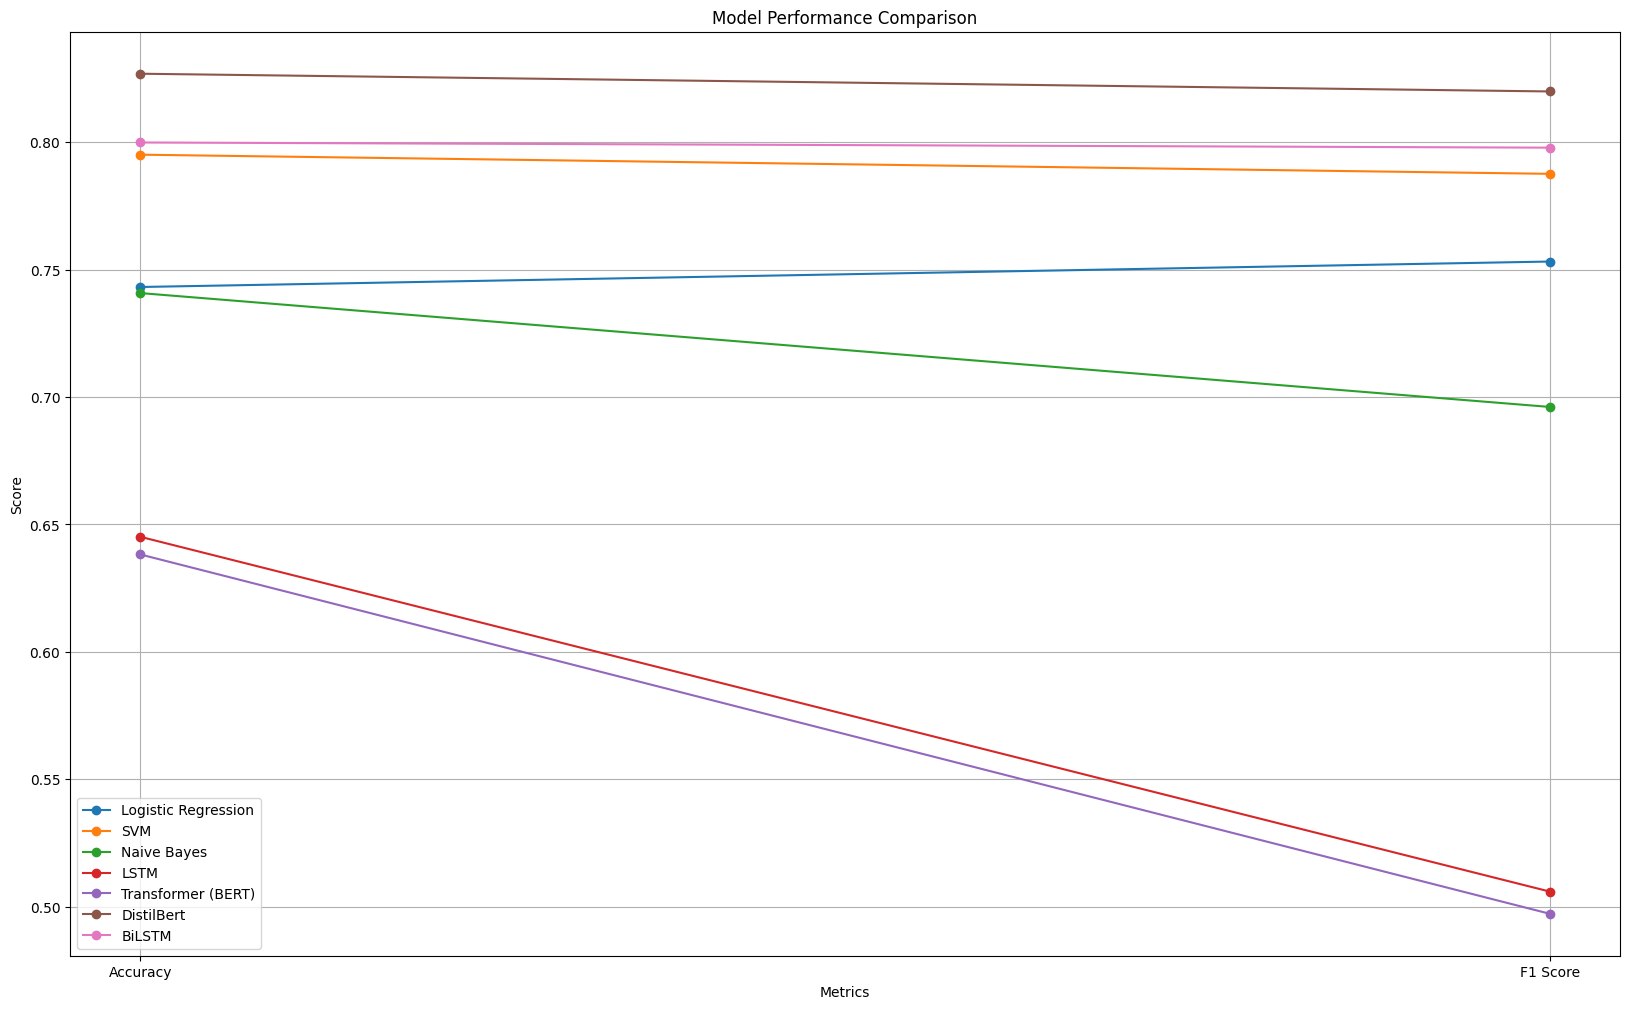

In [ ]:
def plot_model_comparisons(metrics, summary):
    fig, ax = plt.subplots(figsize=(20, 12))

    x = list(metrics)  # Metrics (e.g., Accuracy, F1 Score)
    models = summary["Accuracy"].keys()  # Model names

    for model in models:
        y = [summary[metric][model] for metric in x]
        ax.plot(x, y, marker='o', label=model)

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Score")
    ax.set_title("Model Performance Comparison")
    ax.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_model_comparisons(metrics_summary.keys(), metrics_summary)